In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geoist as gi
import torch
import argparse
import encoder
import decoder
import discriminator
font_ann=dict(fontsize=12,
              family='Times New Roman',
              )
plt.rc('font',family='Times New Roman')
plt.rcParams['font.size'] = 12
config = {
    "font.family":'Times New Roman',
    "font.size": 12,
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
plt.rcParams.update(config)

In [3]:
def load_args():
    parser = argparse.ArgumentParser(description='gangravity')
    parser.add_argument('-c', '--checkpoint', default='./models/checkpointSH_noisefree_500m_adj.pt',
                        type=str, help='checkpoint file')
    parser.add_argument('-d', '--device', default='cuda:2', type=str, help='computing device')
    parser.add_argument('-l', '--gp', default=10, type=int, help='gradient penalty')
    parser.add_argument('-g', '--n_gp', default=1, type=int)
    parser.add_argument('-b', '--batch_size', default=1, type=int)
    parser.add_argument('-n', '--n_batch', default=150, type=int)
    parser.add_argument('-e', '--epochs', default=100, type=int)
    parser.add_argument('-w', '--world_size', default=3, type=int)
    parser.add_argument('--use_spectral_norm', default=False)
    args =parser.parse_known_args()[0]
    return args

def load_models(args, checkpoint=None):
    netDec = decoder.GravDecoder()
    netDis = discriminator.GravDiscriminator()
    netEnc = encoder.GravEncoder()
    netEnc = netEnc.to(args.device)
    if checkpoint:
        netEnc.load_state_dict(checkpoint['enc_state_dict'])
        netDis.load_state_dict(checkpoint['dis_state_dict'])
    print (netDec, netDis, netEnc)
    return (netDec, netDis, netEnc)
args_gen = load_args()
checkpoint = torch.load(args_gen.checkpoint)
saved_model = ['enc_state_dict','dis_state_dict']
for model_key in saved_model:
    new_keys = list(map(lambda x:x[7:],checkpoint[model_key].keys()))
    checkpoint[model_key] = dict(zip(new_keys,list(checkpoint[model_key].values())))
netDec,netDis,netEnc = load_models(args_gen, checkpoint)
netEnc.eval()

GravDecoder() GravDiscriminator(
  (conv3d_x): ModuleList(
    (0): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (2): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  )
  (conv3d_y): ModuleList(
    (0): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (2): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  )
  (conv3d_z): ModuleList(
    (0): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (2): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  )
  (linear_x): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (linear_y): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (linear_z): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1))
) GravEncoder(
  (pre_conv_layers): ModuleList(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), p

GravEncoder(
  (pre_conv_layers): ModuleList(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (pre_norm_layers): ModuleList(
    (0): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, af

In [4]:
from geoist.pfm import prism, pftrans

x = np.linspace(-1050, 1050, 43, endpoint=True)
y = np.linspace(-900, 850, num=36, endpoint=True)
X, Y = np.meshgrid(x, y)

X = X.flatten()
Y = Y.flatten()
points = np.zeros((43*36, 2))
for i in range(42 * 35):
    points[i, 0] = X[i]
    points[i, 1] = Y[i]
grid_x, grid_y = np.mgrid[-3200:3200:64j, -3200:3200:64j]
true = np.load('recovered_gravity2.npy')
gzcontf = pftrans.upcontinue(grid_x, grid_y, true.T, shape=(64, 64), height=500)
gz500 = gzcontf.reshape(64, 64)

In [5]:
# 单次延拓
with torch.no_grad():
        
        data = gz500
        input_data = data
        dain = data
        input_data = input_data.reshape(1, 64, 64)

        input_data = torch.from_numpy(input_data)
        input_data = input_data.type(torch.FloatTensor)
        input_data = input_data.unsqueeze(0).to(args_gen.device)
        density_rec = netEnc(input_data)
        rec = density_rec.squeeze(0)
        rec = rec.cpu().numpy()
        rec = rec.reshape(64, 64)

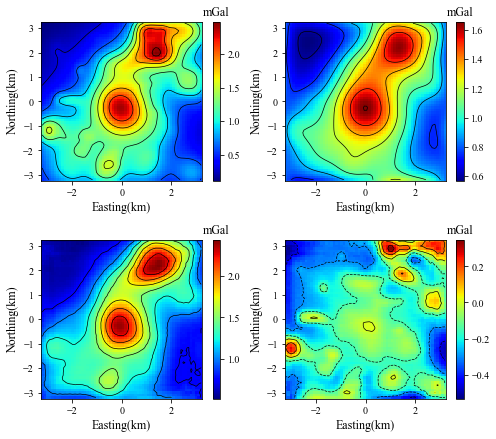

In [6]:
from cProfile import label

plt.figure(figsize=(7, 6.2))
plt.subplot(221)
cf = plt.pcolormesh(grid_x/1000, grid_y/1000, true.T,cmap="jet")
plt.contour(grid_x/1000, grid_y/1000, true.T, colors='k', linewidths=0.7)
plt.xlabel("Easting(km)", fontdict={"size":12})
plt.ylabel("Northing(km)",fontdict={"size":12})
cb = plt.colorbar(cf)
cb.ax.set_title('mGal')

plt.subplot(222)
cf = plt.pcolormesh(grid_x/1000, grid_y/1000, gz500,cmap="jet")
plt.contour(grid_x/1000, grid_y/1000, gz500, colors='k', linewidths=0.7)
plt.xlabel("Easting(km)", fontdict={"size":12})
plt.ylabel("Northing(km)",fontdict={"size":12})
cb = plt.colorbar(cf)
cb.ax.set_title('mGal')

plt.subplot(223)
cf = plt.pcolormesh(grid_x/1000, grid_y/1000, rec,cmap="jet")
plt.contour(grid_x/1000, grid_y/1000, rec, colors='k', linewidths=0.7)
plt.xlabel("Easting(km)", fontdict={"size":12})
plt.ylabel("Northing(km)",fontdict={"size":12})
cb = plt.colorbar(cf)
cb.ax.set_title('mGal')
plt.tight_layout()

plt.subplot(224)
cf = plt.pcolormesh(grid_x/1000, grid_y/1000, true.T-rec,cmap="jet")
plt.contour(grid_x/1000, grid_y/1000, true.T-rec, colors='k', linewidths=0.7)
plt.xlabel("Easting(km)", fontdict={"size":12})
plt.ylabel("Northing(km)",fontdict={"size":12})
cb = plt.colorbar(cf)
cb.ax.set_title('mGal')
plt.tight_layout()
plt.savefig('real.png')
plt.savefig('real.pdf')

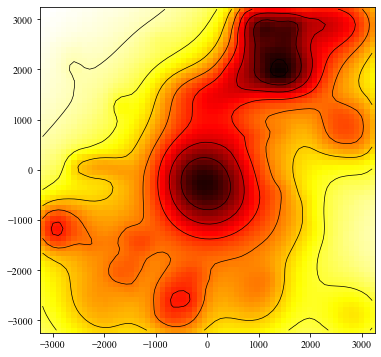

In [7]:
plt.figure(figsize=(6, 6))
cf = plt.pcolormesh(grid_x, grid_y, true.T,cmap="hot_r")
plt.contour(grid_x, grid_y, true.T, colors='k', linewidths=0.7)
plt.savefig('DC-Netout.pdf')

In [8]:
gzcontf1000 = pftrans.upcontinue(grid_x, grid_y, true.T, shape=(64, 64), height=1000)
gz1000 = gzcontf1000.reshape(64, 64)

In [9]:
with torch.no_grad():
        data = gz1000
        input_data = data
        dain = data
        input_data = input_data.reshape(1, 64, 64)

        input_data = torch.from_numpy(input_data)
        input_data = input_data.type(torch.FloatTensor)
        input_data = input_data.unsqueeze(0).to(args_gen.device)
        print(input_data.shape)
        gz_500 = netEnc(input_data)
        
        gz_500 = gz_500.reshape(1, 1, 64, 64)
        print(gz_500.shape)
        
        gz_000 = netEnc(gz_500)
        rec = gz_000.squeeze(0)
        rec = rec.cpu().numpy()
        rec = rec.reshape(64, 64)

torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])


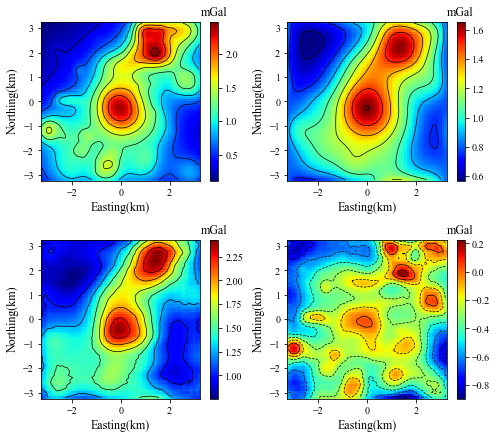

In [10]:
plt.figure(figsize=(7, 6.2))
plt.subplot(221)
cf = plt.pcolormesh(grid_x/1000, grid_y/1000, true.T,cmap="jet")
plt.contour(grid_x/1000, grid_y/1000, true.T, colors='k', linewidths=0.7)
plt.xlabel("Easting(km)", fontdict={"size":12})
plt.ylabel("Northing(km)",fontdict={"size":12})
cb = plt.colorbar(cf)
cb.ax.set_title('mGal')

plt.subplot(222)
cf = plt.pcolormesh(grid_x/1000, grid_y/1000, gz500,cmap="jet")
plt.contour(grid_x/1000, grid_y/1000, gz500, colors='k', linewidths=0.7)
plt.xlabel("Easting(km)", fontdict={"size":12})
plt.ylabel("Northing(km)",fontdict={"size":12})
cb = plt.colorbar(cf)
cb.ax.set_title('mGal')

plt.subplot(223)
cf = plt.pcolormesh(grid_x/1000, grid_y/1000, rec,cmap="jet")
plt.contour(grid_x/1000, grid_y/1000, rec, colors='k', linewidths=0.7)
plt.xlabel("Easting(km)", fontdict={"size":12})
plt.ylabel("Northing(km)",fontdict={"size":12})
cb = plt.colorbar(cf)
cb.ax.set_title('mGal')
plt.tight_layout()

plt.subplot(224)
cf = plt.pcolormesh(grid_x/1000, grid_y/1000, true.T-rec,cmap="jet")
plt.contour(grid_x/1000, grid_y/1000, true.T-rec, colors='k', linewidths=0.7)
plt.xlabel("Easting(km)", fontdict={"size":12})
plt.ylabel("Northing(km)",fontdict={"size":12})
cb = plt.colorbar(cf)
cb.ax.set_title('mGal')
plt.tight_layout()
plt.savefig('realmtl.png')
plt.savefig('realmtl.pdf')

In [11]:
data = np.loadtxt("kauring-g.dat").T

In [12]:
X = data[0]
Y = data[1]
grav = data[2]
Xa = X-np.mean(X)
Ya = Y-np.mean(Y)
grav = grav - np.min(grav)

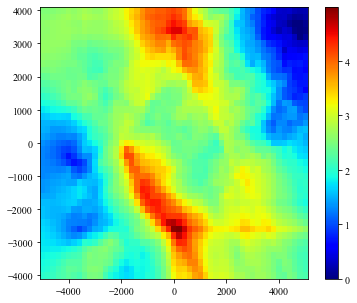

In [13]:
plt.figure(figsize=(6, 5))
plt.pcolormesh(Xa.reshape(41, 51), Ya.reshape(41, 51), grav.reshape(41, 51), cmap='jet')
plt.colorbar()

In [14]:
X_new = np.linspace(-3150, 3150, num=64, endpoint=True)
Y_new = X_new
x_array, y_array = np.meshgrid(X_new, Y_new)

In [15]:
from scipy.interpolate import griddata
gradz = griddata((Xa, Ya), grav, (x_array, y_array), method='cubic')
gradz.shape

gzcontf500 = pftrans.upcontinue(x_array, y_array, gradz, shape=(64, 64), height=500)

with torch.no_grad():
        data = gzcontf500
        input_data = data
        dain = data
        input_data = input_data.reshape(1, 64, 64)

        input_data = torch.from_numpy(input_data)
        input_data = input_data.type(torch.FloatTensor)
        input_data = input_data.unsqueeze(0).to(args_gen.device)
        print(input_data.shape)
        gz_500 = netEnc(input_data)
        
        rec = gz_500.squeeze(0)
        rec = rec.cpu().numpy()
        rec = rec.reshape(64, 64)

torch.Size([1, 1, 64, 64])


In [16]:
x_array = x_array/1000
y_array = y_array/1000

MSE of NDC-Net: 0.1081149000980764
MSE of DC-Net: 0.10883080888465174


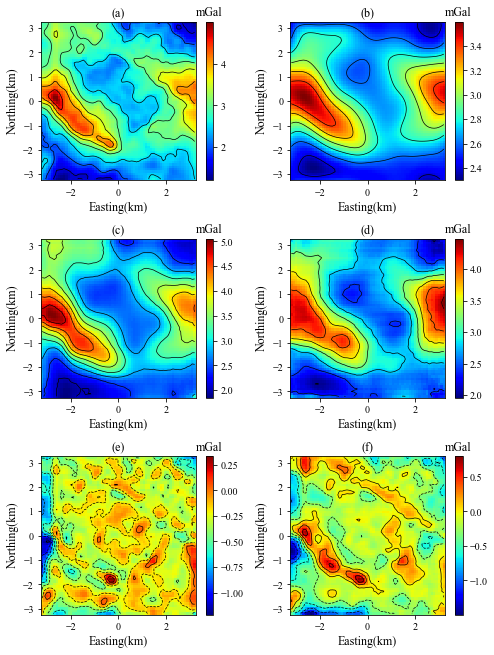

In [17]:
import matplotlib
plt.figure(figsize=(7, 9.2))

plt.subplot(321)
cf = plt.pcolormesh(grid_x/1000, grid_y/1000, gradz.reshape(64, 64),cmap="jet")
plt.contour(grid_x/1000, grid_y/1000, gradz.reshape(64, 64), colors='k', linewidths=0.7)
plt.xlabel("Easting(km)", fontdict={"size":12})
plt.ylabel("Northing(km)",fontdict={"size":12})
plt.title('(a)')
cb = plt.colorbar(cf)
cb.ax.set_title('mGal')

plt.subplot(322)
cf = plt.pcolormesh(grid_x/1000, grid_y/1000, gzcontf500.reshape(64, 64),cmap="jet")
plt.contour(grid_x/1000, grid_y/1000, gzcontf500.reshape(64, 64), colors='k', linewidths=0.7)
plt.xlabel("Easting(km)", fontdict={"size":12})
plt.ylabel("Northing(km)",fontdict={"size":12})
plt.title('(b)')
cb = plt.colorbar(cf)
cb.ax.set_title('mGal')

data = np.load('realnoise.npy')
plt.subplot(323)
cf = plt.pcolormesh(grid_x/1000, grid_y/1000, data,cmap="jet")
plt.contour(grid_x/1000, grid_y/1000, data, colors='k', linewidths=0.7)
plt.xlabel("Easting(km)", fontdict={"size":12})
plt.ylabel("Northing(km)",fontdict={"size":12})
plt.title('(c)')
cb = plt.colorbar(cf)
cb.ax.set_title('mGal')
mse = np.sum((gradz.flatten()-data.flatten())**2)/(64*64)
print('MSE of NDC-Net:', mse)

plt.subplot(324)
cf = plt.pcolormesh(grid_x/1000, grid_y/1000, rec,cmap="jet")
plt.contour(grid_x/1000, grid_y/1000, rec, colors='k', linewidths=0.7)
plt.title('(d)')
plt.xlabel("Easting(km)", fontdict={"size":12})
plt.ylabel("Northing(km)",fontdict={"size":12})
cb = plt.colorbar(cf)
cb.ax.set_title('mGal')
mse = np.sum((gradz.flatten()-rec.flatten())**2)/(64*64)
print('MSE of DC-Net:', mse)

plt.subplot(325)
cf = plt.pcolormesh(grid_x/1000, grid_y/1000, gradz.reshape(64, 64)-data,cmap="jet")
plt.contour(grid_x/1000, grid_y/1000, gradz.reshape(64, 64)-data, colors='k', linewidths=0.7)
plt.title('(e)')
plt.xlabel("Easting(km)", fontdict={"size":12})
plt.ylabel("Northing(km)",fontdict={"size":12})
cb = plt.colorbar(cf)
cb.ax.set_title('mGal')
mse = np.sum((gradz.flatten()-rec.flatten())**2)/(64*64)

plt.subplot(326)
cf = plt.pcolormesh(grid_x/1000, grid_y/1000, gradz.reshape(64, 64)-rec,cmap="jet")
plt.contour(grid_x/1000, grid_y/1000, gradz.reshape(64, 64)-rec, colors='k', linewidths=0.7)
plt.title('(f)')
plt.xlabel("Easting(km)", fontdict={"size":12})
plt.ylabel("Northing(km)",fontdict={"size":12})
cb = plt.colorbar(cf)
cb.ax.set_title('mGal')
mse = np.sum((gradz.flatten()-rec.flatten())**2)/(64*64)

plt.tight_layout()
plt.savefig('real2.png')
plt.savefig('real2.pdf')

MSE of NDC-Net: 0.1081149000980764
MSE of DC-Net: 0.10883080888465174


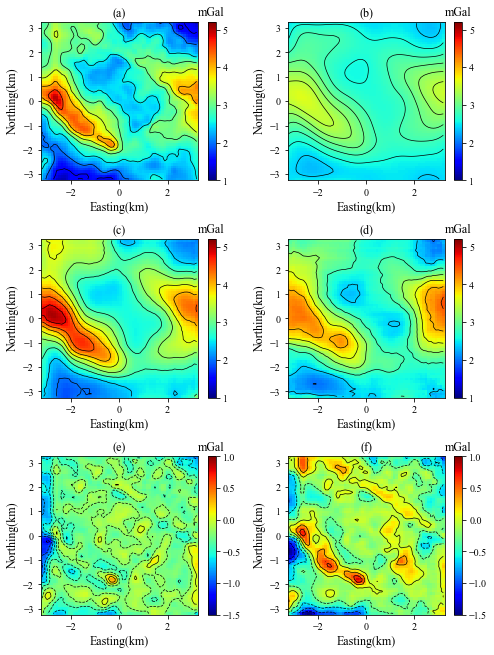

In [18]:
norm = matplotlib.colors.Normalize(vmin=1, vmax=5.2)
norm1 = matplotlib.colors.Normalize(vmin=-1.5, vmax=1)
plt.figure(figsize=(7, 9.2))
plt.subplot(321)
cf = plt.pcolormesh(grid_x/1000, grid_y/1000, gradz.reshape(64, 64),cmap="jet", norm = norm)
plt.contour(grid_x/1000, grid_y/1000, gradz.reshape(64, 64), colors='k', linewidths=0.7)
plt.xlabel("Easting(km)", fontdict={"size":12})
plt.ylabel("Northing(km)",fontdict={"size":12})
plt.title('(a)')
cb = plt.colorbar(cf)
cb.ax.set_title('mGal')

plt.subplot(322)
cf = plt.pcolormesh(grid_x/1000, grid_y/1000, gzcontf500.reshape(64, 64),cmap="jet", norm = norm)
plt.contour(grid_x/1000, grid_y/1000, gzcontf500.reshape(64, 64), colors='k', linewidths=0.7)
plt.xlabel("Easting(km)", fontdict={"size":12})
plt.ylabel("Northing(km)",fontdict={"size":12})
plt.title('(b)')
cb = plt.colorbar(cf)
cb.ax.set_title('mGal')

data = np.load('realnoise.npy')
plt.subplot(323)
cf = plt.pcolormesh(grid_x/1000, grid_y/1000, data,cmap="jet", norm = norm)
plt.contour(grid_x/1000, grid_y/1000, data, colors='k', linewidths=0.7)
plt.xlabel("Easting(km)", fontdict={"size":12})
plt.ylabel("Northing(km)",fontdict={"size":12})
plt.title('(c)')
cb = plt.colorbar(cf)
cb.ax.set_title('mGal')
mse = np.sum((gradz.flatten()-data.flatten())**2)/(64*64)
print('MSE of NDC-Net:', mse)

plt.subplot(324)
cf = plt.pcolormesh(grid_x/1000, grid_y/1000, rec,cmap="jet", norm = norm)
plt.contour(grid_x/1000, grid_y/1000, rec, colors='k', linewidths=0.7)
plt.title('(d)')
plt.xlabel("Easting(km)", fontdict={"size":12})
plt.ylabel("Northing(km)",fontdict={"size":12})
cb = plt.colorbar(cf)
cb.ax.set_title('mGal')
mse = np.sum((gradz.flatten()-rec.flatten())**2)/(64*64)
print('MSE of DC-Net:', mse)

plt.subplot(325)
cf = plt.pcolormesh(grid_x/1000, grid_y/1000, gradz.reshape(64, 64)-data,cmap="jet", norm = norm1)
plt.contour(grid_x/1000, grid_y/1000, gradz.reshape(64, 64)-data, colors='k', linewidths=0.7)
plt.title('(e)')
plt.xlabel("Easting(km)", fontdict={"size":12})
plt.ylabel("Northing(km)",fontdict={"size":12})
cb = plt.colorbar(cf)
cb.ax.set_title('mGal')
mse = np.sum((gradz.flatten()-rec.flatten())**2)/(64*64)

plt.subplot(326)
cf = plt.pcolormesh(grid_x/1000, grid_y/1000, gradz.reshape(64, 64)-rec,cmap="jet", norm = norm1)
plt.contour(grid_x/1000, grid_y/1000, gradz.reshape(64, 64)-rec, colors='k', linewidths=0.7)
plt.title('(f)')
plt.xlabel("Easting(km)", fontdict={"size":12})
plt.ylabel("Northing(km)",fontdict={"size":12})
cb = plt.colorbar(cf)
cb.ax.set_title('mGal')
mse = np.sum((gradz.flatten()-rec.flatten())**2)/(64*64)

plt.tight_layout()
plt.savefig('real22.png')
plt.savefig('real22.pdf')
plt.savefig('figure8.jpg', dpi=300)